In [3000]:
# Prepare train-test split of the generated data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message="`sklearn.utils.parallel.delayed`"
)

df = pd.read_csv("../data/incident_root_cause_data.csv")

df['root_cause_numeric'] = df['root_cause_label'].astype('category').cat.codes
X = df.drop(columns=["root_cause_label"])
y = df["root_cause_numeric"]
print(df[["root_cause_label", "root_cause_numeric"]].head(100))

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


               root_cause_label  root_cause_numeric
0                   memory_leak                   3
1                bad_deployment                   0
2   external_dependency_failure                   2
3   external_dependency_failure                   2
4                cpu_saturation                   1
..                          ...                 ...
95  external_dependency_failure                   2
96                       normal                   4
97                traffic_spike                   5
98                       normal                   4
99                       normal                   4

[100 rows x 2 columns]


In [3001]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Build a baseline logistic regression model pipeline with standard scaling
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000
    ))
])

# Fit the model to the training data
logreg_pipeline.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred_lr = logreg_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_lr))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00       157
           1       1.00      0.98      0.99       125
           2       0.96      0.99      0.98       158
           3       1.00      0.96      0.98       124
           4       0.98      1.00      0.99       116
           5       1.00      1.00      1.00       120

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



In [3002]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))




              precision    recall  f1-score   support

           0       1.00      1.00      1.00       157
           1       1.00      0.99      1.00       125
           2       0.99      1.00      0.99       158
           3       1.00      0.99      1.00       124
           4       1.00      1.00      1.00       116
           5       1.00      1.00      1.00       120

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



In [3003]:
import pandas as pd

feature_importance = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

feature_importance.head(10)


root_cause_numeric     0.537481
mem_growth             0.168319
upstream_error_rate    0.073366
error_rate             0.064147
request_rate           0.052786
dependency_latency     0.037453
latency                0.031086
avg_cpu_usage          0.016332
oom_log_count          0.015709
timeout_log_count      0.003321
dtype: float64

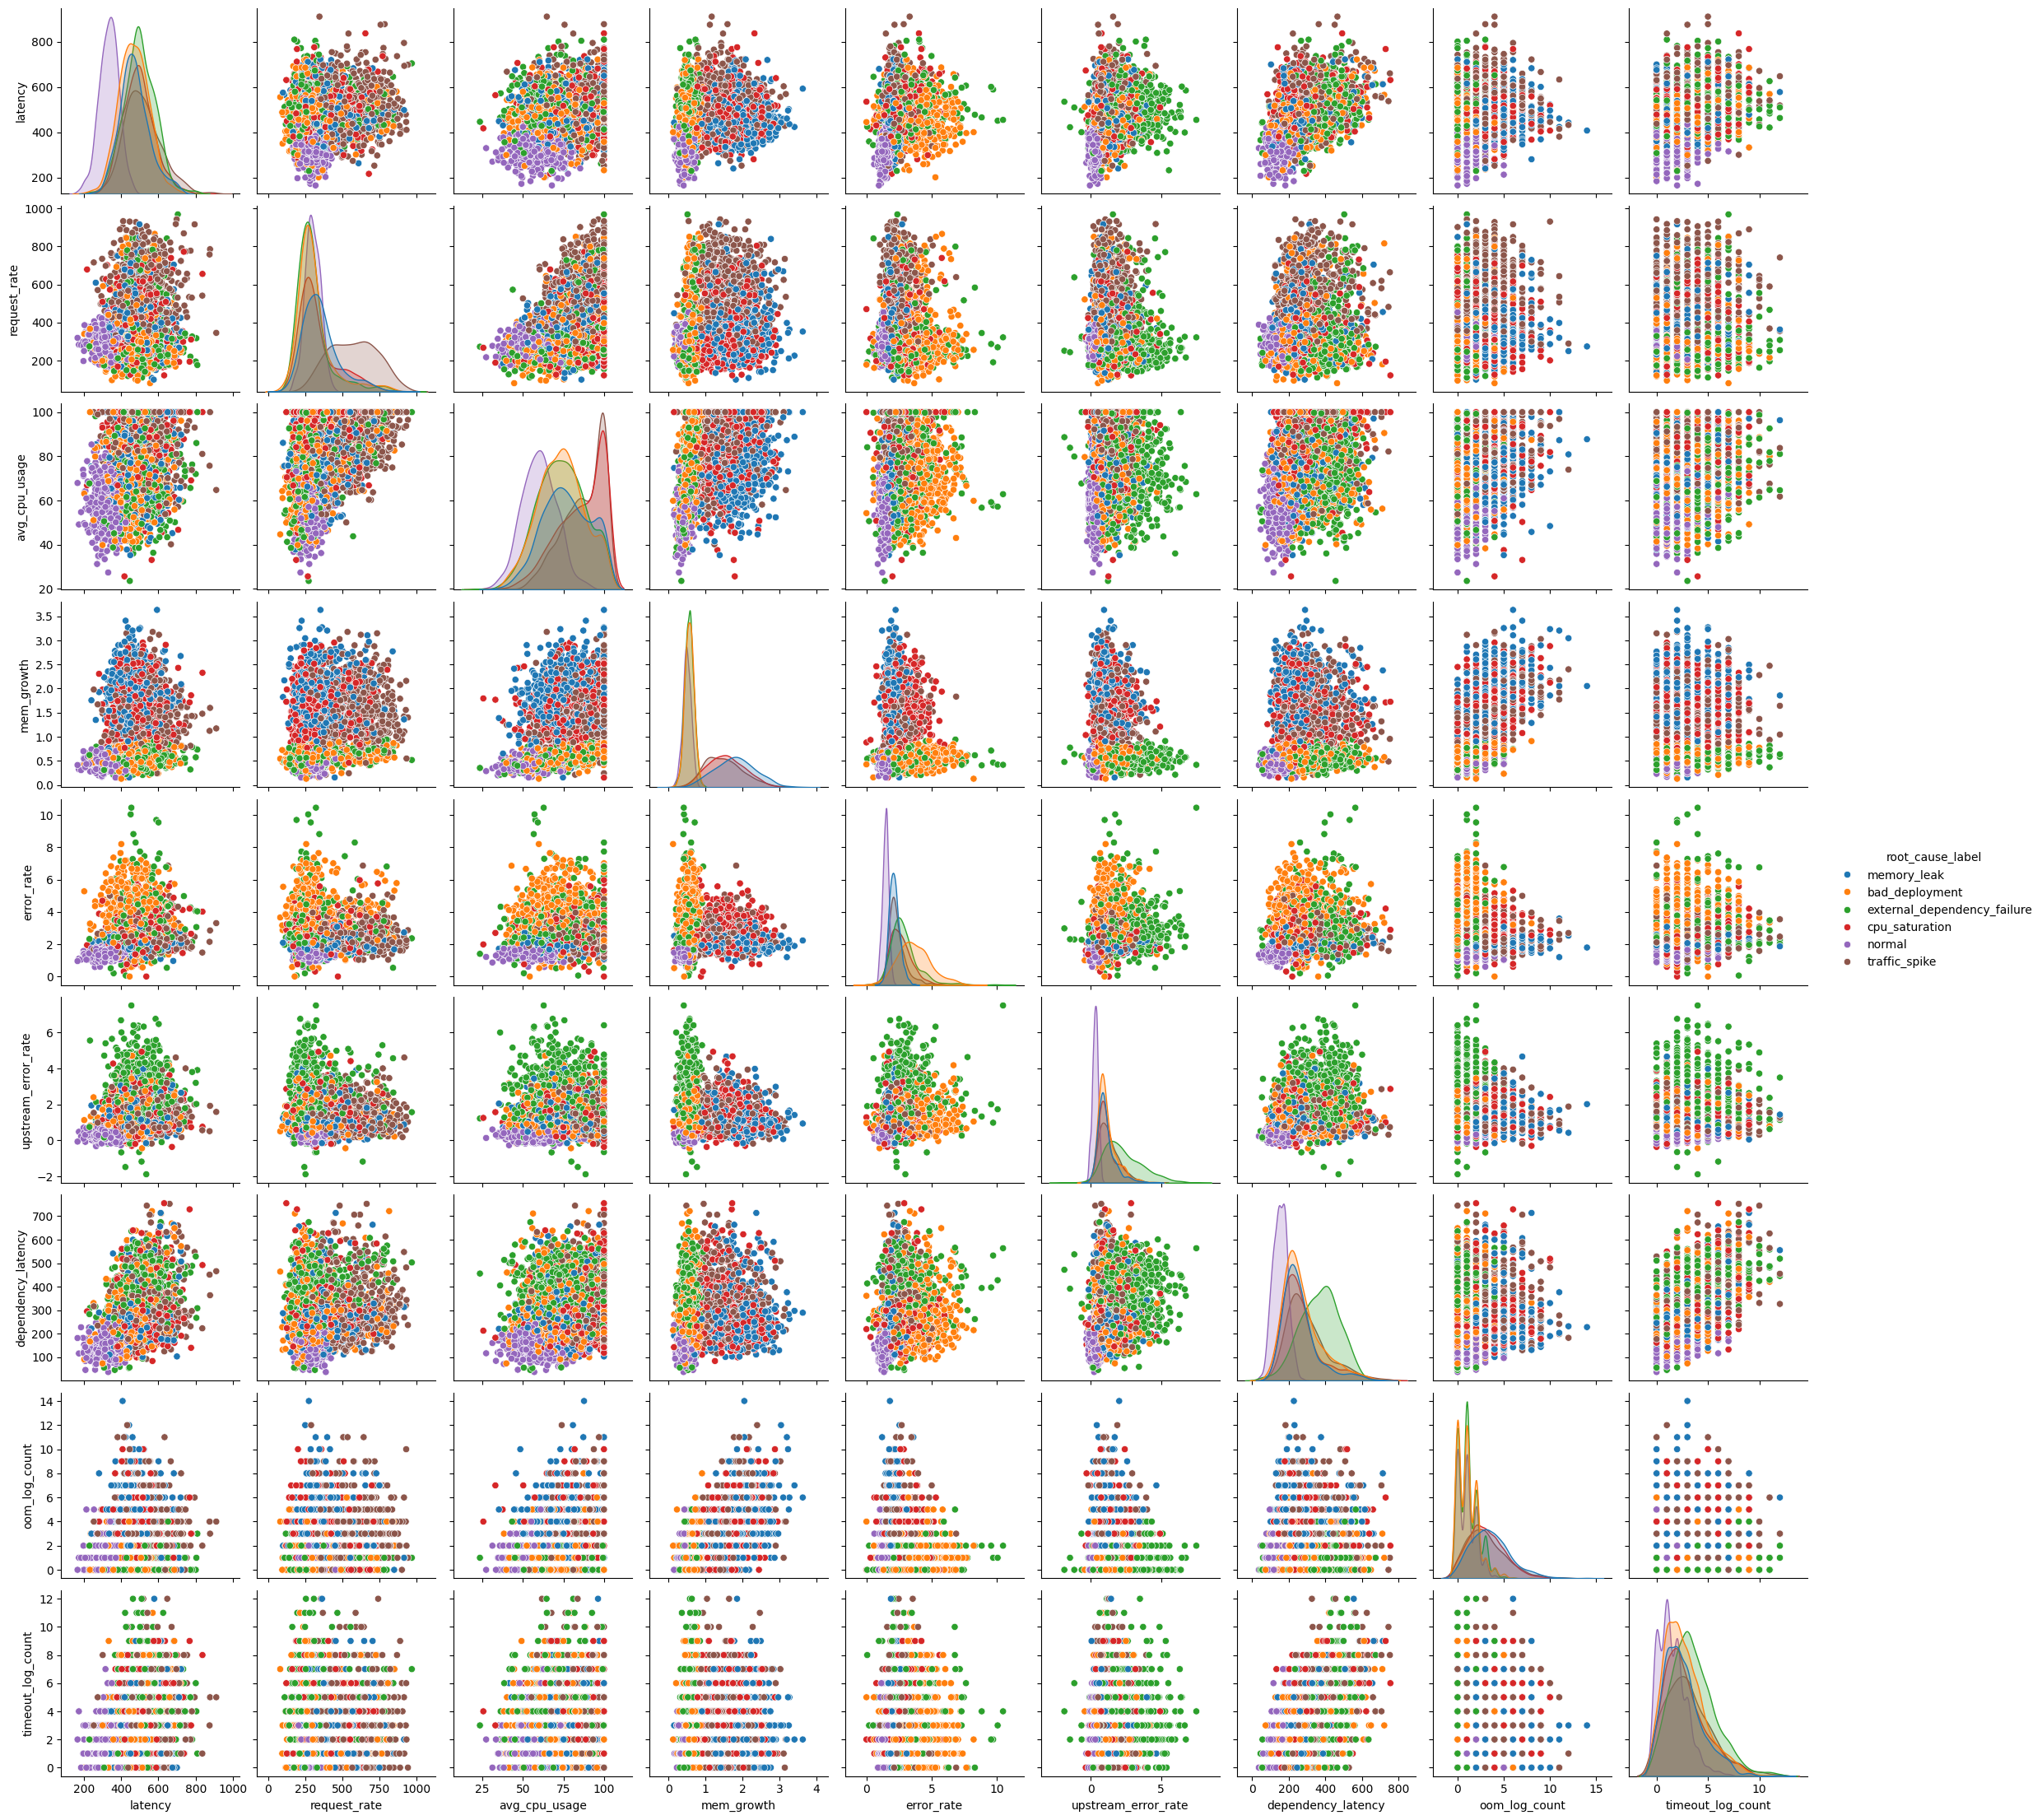

Mean CV accuracy: 0.7365


In [2997]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


# 1. Pairplot to visualize separation
sns.pairplot(df, hue="root_cause_label", vars=[
    'latency','request_rate', 'avg_cpu_usage',
    'mem_growth', 'error_rate',
    'upstream_error_rate', 'dependency_latency',
    'oom_log_count',
    'timeout_log_count'
])
plt.show()


# 2. Quick ML check
X = df[[
    'latency','request_rate', 'avg_cpu_usage',
    'mem_growth', 'error_rate',
    'upstream_error_rate', 'dependency_latency',
    'oom_log_count',
    'timeout_log_count'
    # "request_rate", "avg_cpu_usage", "latency", "error_rate"
    ]]
y = df["root_cause_label"]

clf = RandomForestClassifier(n_estimators=100, random_state=42)
scores = cross_val_score(clf, X, y, cv=5)
print("Mean CV accuracy:", scores.mean())

Mean CV accuracy: 0.7365
Test accuracy: 0.7366666666666667
Confusion matrix:
 [[188   1  40   0   4   2]
 [  3 109   4  37   0  34]
 [ 49   2 184   0   2   1]
 [  4  35   1 107   1  38]
 [  3   0   0   0 171   0]
 [  6  15   8  26   0 125]]


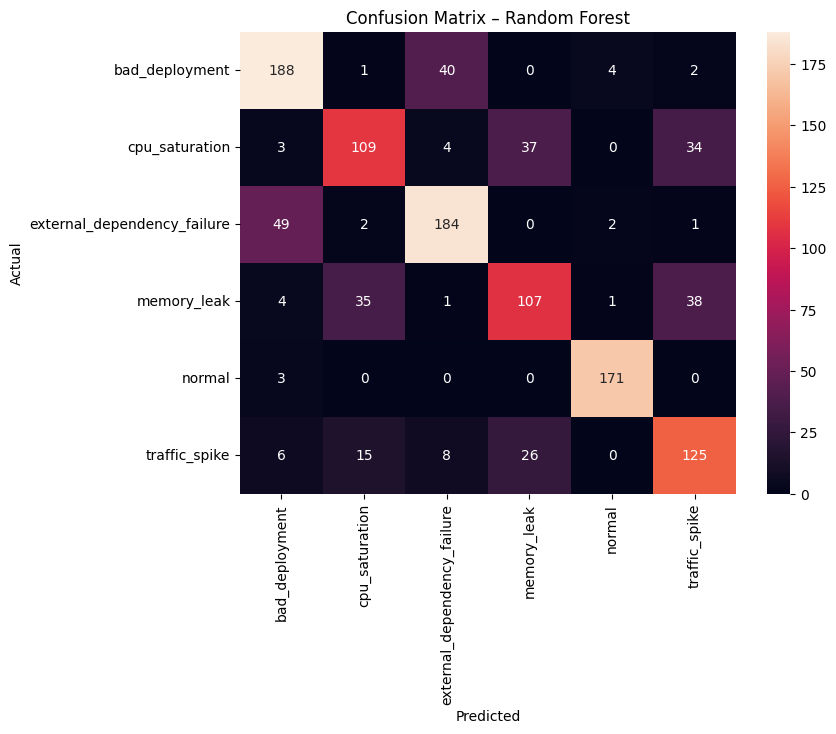

In [3004]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

X = df[[
    # "request_rate","avg_cpu_usage","latency","error_rate"
    'latency','request_rate', 'avg_cpu_usage',
    'mem_growth', 'error_rate',
    'upstream_error_rate', 'dependency_latency',
    'oom_log_count',
    'timeout_log_count'
    ]]
y = df["root_cause_label"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

scores = cross_val_score(clf, X, y, cv=5)
print("Mean CV accuracy:", scores.mean())

print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=clf.classes_,
            yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest")
plt.show()



In [2999]:
# df.groupby("root_cause_label")["oom_log_count"].describe()
df.groupby("root_cause_label")["request_rate"].describe()

# df.groupby("root_cause_label")["avg_cpu_usage"].describe()

count        mean         std         min  \
root_cause_label                                                         
bad_deployment               783.0  311.109468  126.888755   81.145544   
cpu_saturation               624.0  335.373662  132.553793  122.305283   
external_dependency_failure  793.0  302.357191  121.222196  110.874940   
memory_leak                  622.0  355.773294  127.104248   99.961962   
normal                       579.0  299.333383   51.315783  166.334052   
traffic_spike                599.0  573.827426  159.302871  210.469081   

                                    25%         50%         75%         max  
root_cause_label                                                             
bad_deployment               238.240650  278.702352  336.678958  866.093155  
cpu_saturation               245.528761  296.183181  384.815581  803.690809  
external_dependency_failure  229.188953  276.227847  325.858433  968.614450  
memory_leak                  267.177502  333.298028  409.418012  916.345926  
normal                       264.639382  297.983304  336.485500  453.778798  
traffic_spike                442.227215  576.674355  695.491925  942.522250